# Lending Club Note Status Prediction

###### Table of contents
1. [Introduction](#introduction)
2. [Data](#data)
3. [Model Training and Evaluation](#model)

In [195]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import nltk
import string
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

from collections import defaultdict

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## 1. Introduction <a name="introduction"></a>

In this project, I conducted the sentimental analysis on the kindle book reviews. In the training dataset, each book review is labeled as 'positive' or 'negative' based on the review content. The goal of this project is to build a predict model to analysis sentiment of the new comments. I'll go through the basic steps of the Natural Language Processing (NLP) and use the Multinomial Naive Bayes algorithm for sentiment prediction. 

## 2. Data <a name="data"></a>
The amazon book review data include two columns. The "reviewText" is the raw user review of a certain book, and the "overall", which only has two values ("pos" and "neg") is used to represent "positive" and "negative". In total, the training dataset has 126,871 reviews. For the text data, I'll follow the steps to extract features for the model trainng.
1. tokenize
2. normalization
3. bag of words
4. tf-idf vectorizer

In [3]:
# Load csv file into DataFrame
amz_df = pd.read_csv('../../../01_Data/05_amazon/sampled_data.csv')
amz_df.shape

(126871, 2)

In [4]:
amz_df.head()

,overall,reviewText
0,pos,This book ended even before it started and it ...
1,pos,This is a great read with so much emotion you ...
2,pos,"It&#8217;s Christmas Eve and miraculously, Sal..."
3,pos,I enjoyed meeting the character of Cassandra. ...
4,pos,"Can I be the next Hunter wife? Again, I have ..."


In [5]:
amz_df['overall'].value_counts()

pos    64559
neg    62312
Name: overall, dtype: int64

### lemmatization and stemming difference:<br>
In many languages, words appear in several inflected forms. For example, in English, the verb 'to walk' may appear as 'walk', 'walked', 'walks' or 'walking'. The base form, 'walk', that one might look up in a dictionary, is called the lemma for the word. The association of the base form with a part of speech is often called a lexeme of the word.

Lemmatisation is closely related to stemming. The difference is that a stemmer operates on a single word without knowledge of the context, and therefore cannot discriminate between words which have different meanings depending on part of speech. However, stemmers are typically easier to implement and run faster. The reduced "accuracy" may not matter for some applications. In fact, when used within information retrieval systems, stemming improves query recall accuracy, or true positive rate, when compared to lemmatisation. Nonetheless, stemming reduces precision, or true negative rate, for such systems.[5]

For instance:

The word "better" has "good" as its lemma. This link is missed by stemming, as it requires a dictionary look-up.
The word "walk" is the base form for the word "walking", and hence this is matched in both stemming and lemmatisation.
The word "meeting" can be either the base form of a noun or a form of a verb ("to meet") depending on the context; e.g., "in our last meeting" or "We are meeting again tomorrow". Unlike stemming, lemmatisation attempts to select the correct lemma depending on the context.

In [7]:
#lemmatization operator
lemmatizer = nltk.WordNetLemmatizer()

In [8]:
#define the stop words
stop = stopwords.words('english')

In [9]:
#define operator to remove puncutation
translation = str.maketrans(string.punctuation, ' '*len(string.punctuation))

In [160]:
#tokenize
def preprocessing(line):
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    
    tokens = []
    line = str(line).translate(translation) #replace puncutuation
    line = nltk.word_tokenize(line.lower()) #tokenize
    
    for t, tag in nltk.pos_tag(line):
        #remove stopwords
        if t not in stop:
            stemmed = lemmatizer.lemmatize(t,tag_map[tag[0]])
            tokens.append(stemmed)
    return ' '.join(tokens)

In [161]:
#preprocess for all
start = time.time()
amz_df['bow'] = [preprocessing(p) for p in amz_df['reviewText']]
end = time.time()
print(end - start)

1327.9646015167236


In [196]:
amz_df.head()

,overall,reviewText,bow
0,pos,This book ended even before it started and it ...,book end even start make want oh oh teaser wan...
1,pos,This is a great read with so much emotion you ...,great read much emotion help become invest plo...
2,pos,"It&#8217;s Christmas Eve and miraculously, Sal...",8217 christmas eve miraculously sally moss get...
3,pos,I enjoyed meeting the character of Cassandra. ...,enjoy meet character cassandra familiar cassan...
4,pos,"Can I be the next Hunter wife? Again, I have ...",next hunter wife draw life want transport one ...


In [163]:
#split traning Ddta & test data
X_train, X_test, y_train, y_test = \
train_test_split(amz_df['bow'], amz_df['overall'], test_size = 0.2, stratify = amz_df['overall'], random_state = 22)

In [164]:
X_train.head()

106130    many thing hate case heavy fold back behind ki...
26782     book perry county series search book three yea...
17912     fill short story make wish full book like stor...
88905     try find self help psychology book go grey how...
47239     basically get book collection place could visi...
Name: bow, dtype: object

In [165]:
y_train.head()

106130    neg
26782     pos
17912     pos
88905     neg
47239     pos
Name: overall, dtype: object

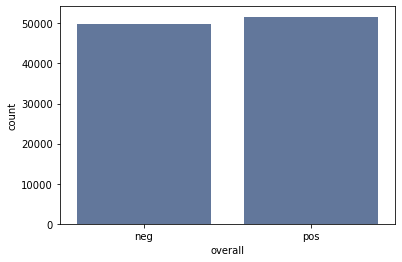

In [166]:
sns.countplot(y_train, order=sorted(y_train.unique()), color = '#5975A4')

In [167]:
#push all tokens and compute frequency of words
t = []
start = time.time()
for line in X_train:
    l = nltk.word_tokenize(line)
    for w in l:
        t.append(w)
word_features = nltk.FreqDist(t)
end = time.time()
print(end-start)

58.596839904785156


In [203]:
len(t)

4186976

In [168]:
word_features.most_common(10)

[('book', 123878),
 ('read', 70205),
 ('story', 62115),
 ('like', 39041),
 ('one', 36693),
 ('love', 34885),
 ('good', 34263),
 ('get', 33511),
 ('character', 30393),
 ('would', 27671)]

In [207]:
#select the top 10000 words as features
topwords = [fpair[0] for fpair in list(word_features.most_common(200))]

In [170]:
print(type(topwords))
print(topwords[:10])
len(topwords)

<class 'list'>
['book', 'read', 'story', 'like', 'one', 'love', 'good', 'get', 'character', 'would']


5000

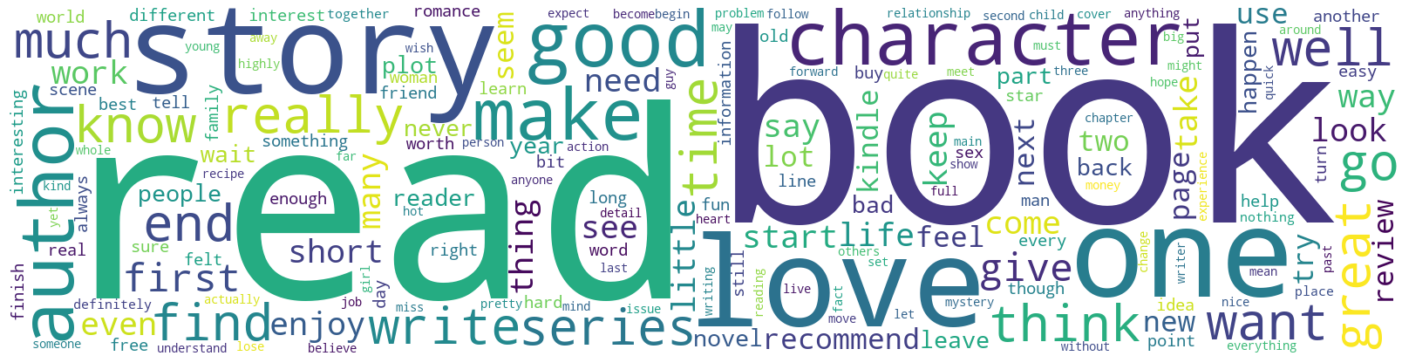

In [211]:
wordcloud = WordCloud(width = 1600, height = 400, max_font_size=300, max_words=200, background_color="white").generate(' '.join(topwords))
plt.figure(figsize = (25,16))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
wordcloud.to_file("words.jpg")

### tf-idf  term weighting

In [171]:
#Since CountVectorizer and TfidfTransfomer are often used together
tf_vec = TfidfVectorizer()

In [172]:
# Extract features from training set
# Vocabulary is from topwords
start = time.time()
train_features  =  tf_vec.fit_transform(X_train)
end = time.time()
print(end-start)

7.020054817199707


In [173]:
len(tf_vec.vocabulary_)

82506

In [174]:
# Extract features from test set
# Vocabulary is from topwords
test_features = tf_vec.transform(X_test)

In [175]:
# (Uni+Bi)-Gram
bg_tf_vec = TfidfVectorizer(ngram_range=(1,2))

In [176]:
# Extract features from training set
# Vocabulary is from topwords
start = time.time()
bg_train_features  =  bg_tf_vec.fit_transform(X_train)
end = time.time()
print(end-start)

30.859305381774902


In [177]:
len(bg_tf_vec.vocabulary_)

1803795

In [178]:
# Extract (uni+bi)-gram test features
bg_test_features = bg_tf_vec.transform(X_test)

### 3. Model Training and Evaluation<a name="model"></a>
### [Multinomial NB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

The multinomial Naive Bayes classifier is suitable for **classification with discrete features** (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [179]:
from sklearn.naive_bayes import MultinomialNB

In [180]:
mnb_model = MultinomialNB()

In [181]:
# Train Model
start = time.time()
mnb_model.fit(train_features, y_train)
end = time.time()

print("Multinomial NB model trained in %f seconds" % (end-start))

Multinomial NB model trained in 0.401924 seconds


In [182]:
# Predict
pred = mnb_model.predict(test_features)
print(pred)

['neg' 'pos' 'pos' ... 'pos' 'neg' 'neg']


In [183]:
# Metrics
# mtrics.accuracy_score(y_true, y_pred)
accuracy = metrics.accuracy_score(pred,y_test)
print(accuracy)

0.8091822660098522


In [184]:
print(metrics.classification_report(y_true=y_test, y_pred=pred))

              precision    recall  f1-score   support

         neg       0.82      0.78      0.80     12463
         pos       0.80      0.84      0.82     12912

   micro avg       0.81      0.81      0.81     25375
   macro avg       0.81      0.81      0.81     25375
weighted avg       0.81      0.81      0.81     25375



In [185]:
mnb_model2 = MultinomialNB()

In [186]:
# Train Model
start = time.time()
mnb_model2.fit(bg_train_features, y_train)
end = time.time()

print("Multinomial NB model trained in %f seconds" % (end-start))

Multinomial NB model trained in 0.658238 seconds


In [187]:
# Predict
bg_pred = mnb_model2.predict(bg_test_features)
print(pred)

['neg' 'pos' 'pos' ... 'pos' 'neg' 'neg']


In [188]:
# Metrics
# mtrics.accuracy_score(y_true, y_pred)
accuracy = metrics.accuracy_score(bg_pred,y_test)
print(accuracy)

0.8330246305418719


In [189]:
print(metrics.classification_report(y_true=y_test, y_pred=bg_pred))

              precision    recall  f1-score   support

         neg       0.87      0.77      0.82     12463
         pos       0.80      0.89      0.84     12912

   micro avg       0.83      0.83      0.83     25375
   macro avg       0.84      0.83      0.83     25375
weighted avg       0.84      0.83      0.83     25375



In [190]:
# Predict a new sentence
# vectorizer needs to be pre-fitted
# At the end of the project, the function signature should be something like:
# predict_new(sentent: str, vec, model) -> str

def predict_new(sentence):
    sentence = preprocessing(sentence)
    features = tf_vec.transform([sentence])
    pred = mnb_model.predict(features)
    return pred[0]

In [191]:
predict_new("I can't stop reading it")

'pos'